# ImmoCheck

This projects purpose is to give an overview how rent and buying prices of real estate changed in vienna over the last years. Therefore certain steps are taken. First of all data gets imported and gathered through different sources. Futher cleaning and stucturing will also be apllied. The main parts like data explanation, analysis and also visulations for better understanding will give you a better understanding on the topic. In the last part, conslusions will be drwan. The cleaned and stuctured data will also be provided as csv files. \
Let's get started!

## Imports

In [47]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import max, median, round
import pyspark 

## Data Gathering

There will be four different sources of data. One Webscarping, one API and two files.

### Webscarping - Cost of real estate

To get data regarding current costs of real estate, data from the webside "Immobilienscout24.at" will be scraped.

In [163]:
i = 1
url = ""
prices = []
while True:
    if i == 1:
        url = 'https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen'
    else:
        url = f'https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-{i}'

    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    postings = soup.find_all('li', {'class': 'Item-item-S33'})
    i += 1
    scraped_vals = 0
    for ele in postings:
        for ele2 in (ele.select('a > section > section:nth-of-type(2) > ul:nth-of-type(1) > li:nth-of-type(2)')):
            prices.append(ele2.getText())
            scraped_vals += 1
    if postings == []:
        break;

    print(url,' scraped values:',scraped_vals)

https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen  scraped values: 13
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-2  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-3  scraped values: 14
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-4  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-5  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-6  scraped values: 12
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-7  scraped values: 14
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-8  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-9  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-10  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnu

The scraped values get converted in a pandas dataFrame.

In [184]:
export_dict = {'vals':prices}
export_df = pd.DataFrame(export_dict)
export_df.head(10)

,vals
0,"ab 5.171,14 €/m²"
1,"ab 9.427,37 €/m²"
2,"ab 6.183,49 €/m²"
3,"ab 5.320,22 €/m²"
4,"ab 9.502,56 €/m²"
5,"ab 8.353,58 €/m²"
6,"ab 5.783,84 €/m²"
7,"ab 7.560,66 €/m²"
8,"ab 6.346,5 €/m²"
9,"ab 7.591,67 €/m²"


Looks good, but for further processing we just need the values.

In [185]:
export_df = export_df.replace('ab','',regex = True)
export_df = export_df.replace('€/m²','',regex = True)
export_df = export_df.replace(' ','',regex = True)
export_df.head(10)

,vals
0,"5.171,14"
1,"9.427,37"
2,"6.183,49"
3,"5.320,22"
4,"9.502,56"
5,"8.353,58"
6,"5.783,84"
7,"7.560,66"
8,"6.346,5"
9,"7.591,67"


Now the format has to be adapted.

In [186]:
export_df = export_df.apply(lambda x: x.str.replace('.',''))
export_df = export_df.apply(lambda x: x.str.replace(',','.'))
export_df.head(10)

C:\Users\marku\AppData\Local\Temp\ipykernel_8788\1430330772.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  export_df = export_df.apply(lambda x: x.str.replace('.',''))


,vals
0,5171.14
1,9427.37
2,6183.49
3,5320.22
4,9502.56
5,8353.58
6,5783.84
7,7560.66
8,6346.5
9,7591.67


Most of the values look good. However, wile scarping we also got some value which can not be further processed.

In [187]:
export_df[export_df['vals'].str.startswith('statt')]

,vals
185,statt620000€-6%
393,statt3100000€-5%
527,statt749000€-7%
553,statt215000€-7%


These values get deleted.

In [188]:
export_df = export_df.drop([185,393,527,553])

Now the value look good and are ready to be exported for later processing.

In [ ]:
export_df.to_csv('./exports/prices.csv', index=False)  

### Excel Import - Cost of real estate

In [ ]:
Excel importieren (bzw .ods weiß grad nicht was das war). Erklärung was für daten das sind, von wann, und die gewollten Daten anzeigen

### REST API - Bevölerungsdaten

API anzapfen und Daten aufbereiten, dass man sie verwenden kann --> schauts einfach im big data infr projekt. Aber wir brauchen hald nur WIEN!!

## Source Data Analysis

We now have gathered information of our four different datasources. Before comparing those to each other, we want to analyse each for itself. Due to that, we want to achieve a better understanding.

### Cost of real estate (Webscraping)


To get a deeper understanding of the data we want to take advantage of a visualation. Therefore, we need to load the already structered and cleaned data again.

In [8]:
spark = SparkSession \
    .builder \
    .appName("ImmoCheck") \
    .getOrCreate()
df = spark.read.csv("./exports/prices.csv",header = True)
print(df)
df.show(5)

DataFrame[vals: string]
+-------+
|   vals|
+-------+
|5171.14|
|9427.37|
|6183.49|
|5320.22|
|9502.56|
+-------+
only showing top 5 rows



The values are loaded. However we have to set the type to float, for using visulations.

In [9]:
df = df.withColumn("vals", df["vals"].cast("float"))
df

DataFrame[vals: float]

<Axes: >

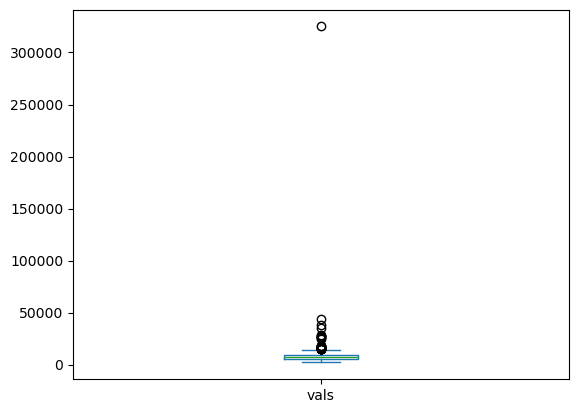

In [34]:
df_p = df.select('*').toPandas()
df_p.dtypes
df_p['vals'] = df_p['vals'].astype('float64')
df_p["vals"].plot.box()  

As we see, there is one outlier, which makes reading the boxplot very hard. So for this visualization, we will ignore this value. (However, it will remain for further processing)

In [27]:
df.select(max('vals')).show()

+---------+
|max(vals)|
+---------+
| 325000.0|
+---------+



In [39]:
df_boxplot = df.where(df.vals!= 325000)

<Axes: >

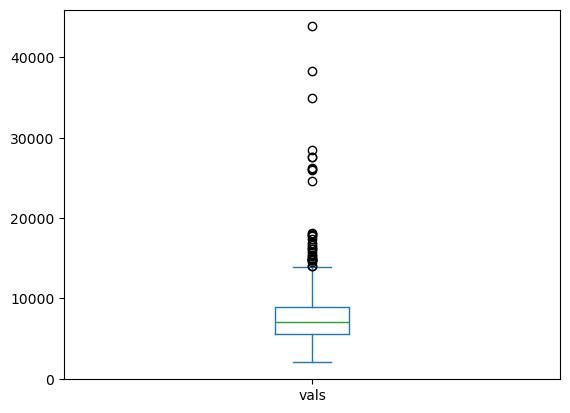

In [41]:
df_p = df_boxplot.select('*').toPandas()
df_p.dtypes
df_p['vals'] = df_p['vals'].astype('float64')
df_p["vals"].plot.box()  

Most of the values are between the lower 4 digits (around 1500) and 15000. The median is slightly under 10000. 
However, it is notable, that there are several values outside of the inner fence. It seems like that there is no limit at the upper end. (Especially if we also take the one value in consideration, which we igbored for this visualization.)

In [49]:
df_median = df.select(round(median('vals'))).show()

+----------------------+
|round(median(vals), 0)|
+----------------------+
|                7028.0|
+----------------------+



The value of the median of our data set is 7028 per square meter.

### REST API (Bevölkerungsdaten)

deskeptive analyse von den Daten, in einem Plot darstellen und hald erklären, wie sich die Daten verändern haben. absolut und prozentuell. 

## Gerneral Analysis

### Cost of real estate (2015 - 2024)

hier die Daten aus der Vergangenheit mit den aktuellen Daten verschneiden. EInfach einen plot.

## Comparison with population growth

hier dann noch abgleich, ob Bevölkerung prozentuell gleich viel gewachsen ist, wie die Preise der Wohnungen pro m2

## Conclusion

hier einfach nochmal ergebnisse zusammenfassen in einem text

## Closing

In [ ]:
spark.stop()